In [786]:
%load_ext autoreload

%autoreload 2
import pickle
import sys
import CL_fiducial_mass_richness_relation as cl
from astropy.table import Table, join
import matplotlib.pyplot as plt
import numpy as np
sys.path.append('../modules/')
import CL_WL_DATAOPS_make_profile as prf
import CL_WL_fit_cluster_mass as fit
import CL_Likelihood_for_Mass_richness_relation as mr
import analysis_Mass_Richness_relation as analysis
import CL_fiducial_mass_richness_relation as fiducial

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [787]:
Z_bin = analysis.Z_bin
Obs_bin = analysis.Obs_bin

In [788]:
def load(filename, **kwargs):
    with open(filename, 'rb') as fin:
        return pickle.load(fin, **kwargs)

dat_RM = load('/pbs/throng/lsst/users/cpayerne/ThesisAtCCin2p3/Galaxy_Cluster_Catalogs_details/cosmoDC2/RedMapper_galaxy_clusters.pkl')
dat_cosmodc2 = load('/pbs/throng/lsst/users/cpayerne/ThesisAtCCin2p3/Galaxy_Cluster_Catalogs_details/cosmoDC2/SkySim5000_DM_halos.pkl')
dat_cosmodc2['M200c'] = dat_cosmodc2['baseDC2/sod_halo_mass']/0.71
dat_cosmodc2 = dat_cosmodc2

In [789]:
richness_catalog = Table({'obs':dat_RM['richness'], 'ra':dat_RM['ra'], 'dec':dat_RM['dec'],'redshift':dat_RM['redshift'], 'id':np.arange(len(dat_RM['redshift']))})

In [790]:
mass_catalog = Table({'obs':dat_cosmodc2['M200c'], 'ra':dat_cosmodc2['ra'], 'dec':dat_cosmodc2['dec'],'redshift':dat_cosmodc2['redshift'],'id':np.arange(len(dat_cosmodc2['redshift']))})
mass_catalog = mass_catalog[mass_catalog['redshift']<1.2]
mass_catalog = mass_catalog[mass_catalog['redshift']>.2]
mass_catalog = mass_catalog[mass_catalog['obs']>3e13]

In [791]:
match_table_my=cl.match_catalog(mass_catalog, richness_catalog, clevar=False)

In [792]:
match_table_clevar=cl.match_catalog(mass_catalog, richness_catalog, clevar=True)


## ClCatalog 1
## Prep mt_cols
* zmin|zmax from config value
* ang radius from set scale

## ClCatalog 2
## Prep mt_cols
* zmin|zmax from config value
* ang radius from set scale

## Multiple match (catalog 1)
Finding candidates (Cat1)
* 4,932/48,762 objects matched.

## Multiple match (catalog 2)
Finding candidates (Cat2)
* 3,792/3,895 objects matched.

## Finding unique matches of catalog 1
Unique Matches (Cat1)
* 4,322/48,762 objects matched.

## Finding unique matches of catalog 2
Unique Matches (Cat2)
* 3,792/3,895 objects matched.
Cross Matches (Cat1)
* 3,791/48,762 objects matched.
Cross Matches (Cat2)
* 3,791/3,895 objects matched.


In [804]:
binned_clevar=cl.make_binned(match_table_clevar['mass_1'], match_table_clevar['mass_2'], match_table_clevar['z_1'], Z_bin = Z_bin, Richness_bin = Obs_bin)

In [805]:
binned_my=cl.make_binned(match_table_my['obs_1'], match_table_my['obs_2'], match_table_my['redshift_1'], Z_bin = Z_bin, Richness_bin = Obs_bin)

[]

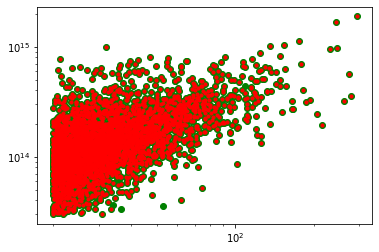

In [816]:
plt.scatter(match_table_clevar['mass_2'],match_table_clevar['mass_1'],c='g')
plt.scatter(match_table_my['obs_2'],match_table_my['obs_1'],c='r', s=10)
plt.loglog()

[]

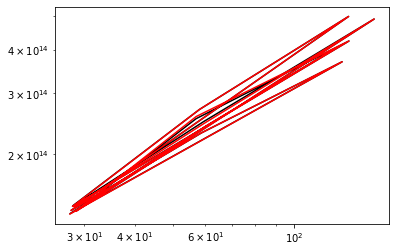

In [818]:
plt.plot( 10**np.array(binned_my['logrichness']), binned_my['m200'],c='k')
plt.plot( 10**np.array(binned_clevar['logrichness']), binned_clevar['m200'],c='r')
plt.loglog()

# purity and completness

In [809]:
logm = np.linspace(np.log10(3e13), 15, 10)
richness=np.linspace(20, 100, 10)
z=np.linspace(.2, 1., 10)

In [810]:
binned_true_mass_cat, axis1_mass, axis2_z =np.histogram2d(np.log10(mass_catalog['obs']), mass_catalog['redshift'], bins=[logm, z])

In [811]:
binned_matched_mass_cat, axis1_mass, axis2_z =np.histogram2d(np.log10(match_table_my['obs_1']), match_table_my['redshift_1'], bins=[logm, z])

In [812]:
binned_true_richness_cat, axis1_richness, axis2_z =np.histogram2d(richness_catalog['obs'], richness_catalog['redshift'], bins=[richness, z])

In [813]:
binned_matched_richness_cat, axis1_richness, axis2_z =np.histogram2d(match_table_my['obs_2'], match_table_my['redshift_2'], bins=[richness, z])

/pbs/home/c/cpayerne/.conda/envs/mydesc/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


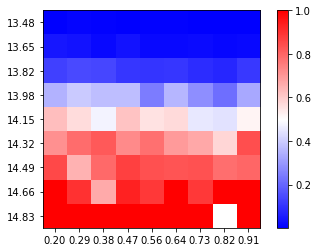

In [814]:
completness = binned_matched_mass_cat/binned_true_mass_cat
plt.imshow(completness, cmap='bwr')
plt.yticks(ticks=np.arange(len(axis1_mass)-1), labels=[f'{s:.2f}' for s in axis1_mass]) 
plt.xticks(ticks=np.arange(len(axis2_z)-1), labels=[f'{s:.2f}' for s in axis2_z]) 
plt.colorbar()

/pbs/home/c/cpayerne/.conda/envs/mydesc/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


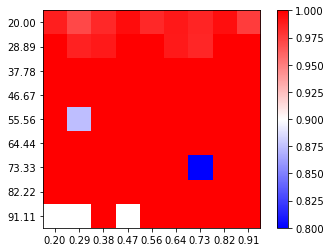

In [815]:
purity = binned_matched_richness_cat/binned_true_richness_cat
plt.yticks(ticks=np.arange(len(axis1_richness)-1), labels=[f'{s:.2f}' for s in axis1_richness]) 
plt.xticks(ticks=np.arange(len(axis2_z)-1), labels=[f'{s:.2f}' for s in axis2_z]) 
plt.imshow(purity, cmap='bwr')
plt.colorbar()

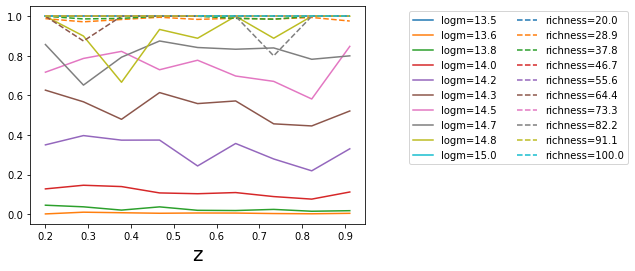

In [803]:
for i, m in enumerate(logm):
    plt.plot(axis2_z[:-1], completness[i-1,:], label=f'logm={m:.1f}')
for i, rich in enumerate(richness):
    plt.plot(axis2_z[:-1], purity[i-1,:], '--', label=f'richness={rich:.1f}')
plt.xlabel('z', fontsize=20)
plt.legend(ncol=2,bbox_to_anchor=(0,0,1.8,1), )